In [1]:
# special IPython command to prepare the notebook for matplotlib and other libraries
%matplotlib inline 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import seaborn as sns

In [2]:
def retrieve_data():
    engine =  create_engine('sqlite:///../data/database/happycows.db')
    with engine.connect() as con:
        milk = pd.read_sql_table('milk_volume', con)
        weather = pd.read_sql_table('weather', con)
        score = pd.read_sql_table('classification', con)
        genetics = pd.read_sql_table('genetics', con)
    return milk, weather, score, genetics

def merge_data(milk, weather, score, genetics):
    milk.reset_index()
    weather.reset_index()
    score.reset_index()
    m = pd.merge(left=milk, right=weather, left_on='date', right_on='date')
    m = pd.merge(left=m, right=score, left_on='animal_id', right_on='animal_id')
    m = pd.merge(left=m, right=genetics, left_on='animal_id', right_on='animal_id')
    m = m.reset_index()
    return m

def select_features(data):
    milk_features = ['milk_weight', 'average_flow', 'max_flow']
    weather_features =  ['prcp', 'tmax', 'tmin', 'is_hot', 'is_cold', 'is_heatwave', 'is_coldwave']
    score_features =  ['lactation_count', 'stature', 'strength', 'body_depth',
                       'dairy_form', 'rump_angle', 'rump_width', 'rear_legs_side', 'rear_legs_rear',
                       'locomotion', 'foot_angle', 'fore_udder', 'udder_height', 'udder_width',
                       'udder_cleft', 'udder_depth', 'front_teat_placement', 'rear_teat_placement',
                       'teat_length', 'udder_tilt', 'body_condition', 'front_end_capacity_aggregate',
                       'dairy_strength_aggregate', 'rump_aggregate', 'feet_and_legs_aggregate',
                       'udder_score_aggregate', 'final_score', 'breed_age_average', 'category']
    genetics_features = ['milk', 'ctpi']
    
    features = milk_features + weather_features + score_features + genetics_features
    
    for col in ['category']:
        data[col] = data[col].astype('category')
        
    for col in ['is_hot', 'is_cold', 'is_heatwave', 'is_coldwave']:
        data[col] = data[col].astype('int')
        
    return pd.get_dummies(data[features].dropna(axis=0, how='any'))

def get_data():
    milk, weather, score, genetics = retrieve_data()
    data = merge_data(milk, weather, score, genetics)
    return select_features(data)    

In [3]:
data = get_data()
data.sample(3)

,milk_weight,average_flow,max_flow,prcp,tmax,tmin,is_hot,is_cold,is_heatwave,is_coldwave,...,udder_score_aggregate,final_score,breed_age_average,milk,ctpi,category_Fair,category_Good,category_Good Plus,category_Poor,category_Very Good
45015,13.3,1.40,4.2,0.010,65.0,42.0,0,0,0,0,...,79.0,79.0,101.199997,1004,1761,0,1,0,0,0
30093,47.2,4.55,7.1,0.000,35.5,21.0,0,0,0,0,...,84.0,83.0,105.400002,-858,1479,0,0,1,0,0
78183,37.4,5.20,9.0,0.375,84.0,68.0,0,0,0,0,...,78.0,80.0,100.199997,-524,1291,0,0,1,0,0


In [4]:
y = data['milk_weight']
X = data.drop(labels=['milk_weight'], axis=1)

In [5]:
def plot_model_scatter_plot(y_test, y_pred):

    plt.scatter(y_test, y_pred)
    plt.plot([0,200],[0,200])
    plt.xlabel('Milk Weight Actual')
    plt.ylabel('Milk Weight Predicted')
    plt.show()
    
    residuals = (np.subtract(y_test, y_pred)) 
    normed_residuals = residuals / y_test.std()

    sns.residplot(y=normed_residuals, x=y_test)
    plt.ylabel('Residual Error')
    plt.xlabel('Fitted Values')
    plt.show()

In [6]:
from sklearn.preprocessing import Imputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

Tuned Lasso Alpha: {'lasso__alpha': 0.050000000000000003}
Tuned Lasso R squared: 0.14904954897960832


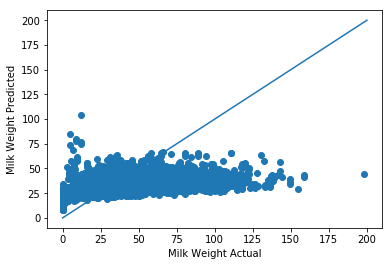

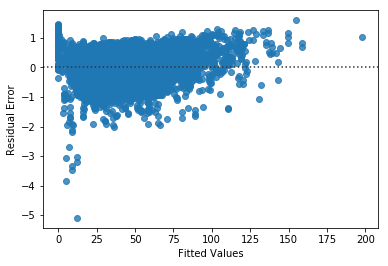

In [7]:
# Setup the pipeline steps: steps
steps = [('imputation', Imputer(missing_values='NaN', strategy='median', axis=0)), 
         ('lasso', Lasso())]

# Create the pipeline: pipeline 
pipeline = Pipeline(steps)

# Specify the hyperparameter space
parameters = {'lasso__alpha':np.arange(0.05, 1.0, 0.05)}

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Create the GridSearchCV object: gm_cv
m_cv = GridSearchCV(pipeline, cv=3, param_grid=parameters)

# Fit to the training set
m_cv.fit(X_train, y_train)

# Compute and print the metrics
r2 = m_cv.score(X_test, y_test)
print("Tuned Lasso Alpha: {}".format(m_cv.best_params_))
print("Tuned Lasso R squared: {}".format(r2))

y_pred = m_cv.predict(X_test)
plot_model_scatter_plot(y_test, y_pred)

Best Paremeters: {'forest__max_features': 'auto', 'forest__n_estimators': 14}
CV_Score: 0.4825564353345891


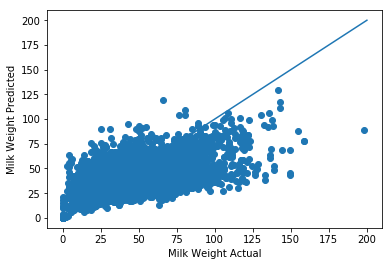

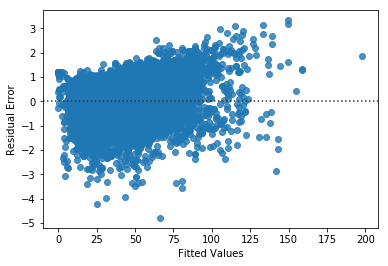

In [8]:
from sklearn.ensemble import RandomForestRegressor

# Setup the pipeline steps: steps
steps = [('imputation', Imputer(missing_values='NaN', strategy='median', axis=0)), 
         ('forest', RandomForestRegressor())]

# Create the pipeline: pipeline 
pipeline = Pipeline(steps)

# Specify the hyperparameter space
parameters = {'forest__n_estimators':np.arange(10, 15, 2),
              'forest__max_features':['auto', 'sqrt', 'log2']}

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Create the GridSearchCV object: gm_cv
m_cv = GridSearchCV(pipeline, cv=3, param_grid=parameters)

# Fit to the training set
m_cv.fit(X_train, y_train)

# Compute and print the metrics
r2 = m_cv.score(X_test, y_test)
print("Best Paremeters: {}".format(m_cv.best_params_))
print("CV_Score: {}".format(r2))

y_pred = m_cv.predict(X_test)
plot_model_scatter_plot(y_test, y_pred)

Best Paremeters: {'gradient__max_features': 'auto', 'gradient__n_estimators': 14}
CV_Score: 0.16629064239199376


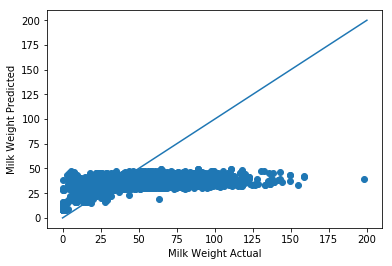

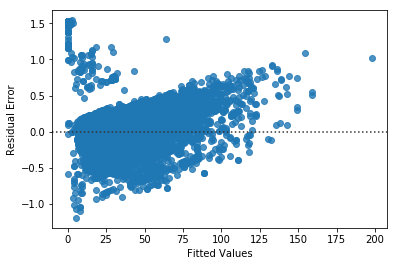

In [10]:
from sklearn.ensemble import GradientBoostingRegressor

# Setup the pipeline steps: steps
steps = [('imputation', Imputer(missing_values='NaN', strategy='median', axis=0)), 
         ('gradient', GradientBoostingRegressor())]

# Create the pipeline: pipeline 
pipeline = Pipeline(steps)

# Specify the hyperparameter space
parameters = {'gradient__n_estimators':np.arange(10, 15, 2),
              'gradient__max_features':['auto', 'sqrt', 'log2']}

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Create the GridSearchCV object: gm_cv
m_cv = GridSearchCV(pipeline, cv=3, param_grid=parameters)

# Fit to the training set
m_cv.fit(X_train, y_train)

# Compute and print the metrics
r2 = m_cv.score(X_test, y_test)
print("Best Paremeters: {}".format(m_cv.best_params_))
print("CV_Score: {}".format(r2))

y_pred = m_cv.predict(X_test)
plot_model_scatter_plot(y_test, y_pred)